# 0 Tasks {-}

For this assignment I make use of two tasks: the cart-pole task and the half-cheetah task. I make small modifications to each of them, which I describe below.

## 0.1 Cart-pole task {-}

The cart-pole task is a classic control task introduced by Sutton and Barto in which a wheeled cart is mounted on a frictionless, finite-length beam. On top of the cart a pole is balanced. The agent's goal is to exert forces on the cart to prevent the pole from falling over without pushing the cart off of the edge of the beam.

For this task, I slightly modified the reward schedule to better reflect the structure of the task. This only affects the reward signals provided to the agent and not the episode returns shown in the graphs. The original cart-pole task does not distinguish between the case where the episode terminates naturally after 1000 timesteps and the case where the pole falls at timestep 1000. Additionally, by providing a positive reward for every timestep when the agent survives, it creates a slow-to-learn value function which will become, except in doomed trajectories, the constant-reward scale factor determined by the formula $\frac{1}{1-\gamma}$. Finally, the agent will be confused that the cumulative return for a timestep soon before the 1000-timestep cutoff will appear lower than the cumulative return at an earlier timestep even with an optimal policy. I rectify all of these issues by providing the agent with a 0 reward signal for every timestep that the pole does not fall and a -1 reward signal for any timestep that the pole does fall. The code that implements this version of the cart-pole problem is included below.

In [2]:
class CartPoleTask:
    def __init__(self, rng):
        self.cartpole_env = gym.make("InvertedPendulumMuJoCoEnv-v0")
        self.cartpole_env.seed(int(rng.integers(2**63-1)))
        self.obs_shape = (4,)
        self.action_shape = (1,)
        self.ts = 0
    def reset(self):
        self.ts = 0
        return self.cartpole_env.reset()
    def step(self, action):
        o, r, t, _ = self.cartpole_env.step(action)
        self.ts += 1
        return o, -1. if t and self.ts != 1000 else 0., t, _
    def render(self):
        return self.cartpole_env.render()
    def get_return(self):
        return self.ts

## 0.2 Half-cheetah task {-}

The half-cheetah task is a locomotion task in which an agent controls a two-dimensional cheetah-like body which is only stable when both legs are on the ground. As such, it can only move far distances by galloping rapidly, resulting in a deceptive-reward problem where the locally optimal behavior is always to take a single step forwards. The half-cheetah's body has 6 joints which are controlled by the agent and 17 proprioceptive position and velocity sensors which provide the agent with input. The agent is rewarded for forwards locomotion and penalized for energy cost.

In order to maintain this challenge, I made only minimal modifications to the half-cheetah task. To reduce the dataset's bias towards states where the cheetah has fallen over, I early-terminate all episodes at 500 timesteps. This affects all episode return calculations. In cases where the agent is successfully galloping, this would roughly half the total return that the agent receives; in cases where the agent becomes stuck and does not move, it does not affect the total return. In cases where the agent is continually exerting torques but not moving successfully, it would roughly half the (negative) total return that the agent receives. The code that implements this version of the half-cheetah task is included below.

In [3]:
class HalfCheetahTask:
    def __init__(self, rng, to_render=False):
        self.env = gym.make("HalfCheetahMuJoCoEnv-v0")
        if to_render:
            self.env.render('human')
        self.env.seed(int(rng.integers(2**63-1)))

        self.obs_shape = (17,)
        self.action_shape = (6,)
        self.cumulative_r = 0
        self.timestep = 0
    def reset(self):
        self.cumulative_r = 0
        self.timestep = 0
        return self.env.reset()
    def step(self, action):
        o, r, t, _ = self.env.step(action)
        self.timestep += 1
        self.cumulative_r += r
        return o, r, t or self.timestep == 500, _
    def render(self):
        return self.env.render('human')
    def get_return(self):
        return self.cumulative_r

## 0.3 Simulation model {-}

The simulation model greedily evaluates the policy every 50 training episodes in order to track how performance changes over time and preserve the best-performing weights.

# 1 Network design {-}

## 1.1 Probabilistic policy using mixture-of-Gaussians {-}

I use a coordinate-wise mixture-of-Gaussians distribution as my stochastic policy; as such, my networks each output the paramaters for this distribution. One regret is that each action coordinate is independent of the others (each of the n action coordinates is determined using a univariate mixture-of-Gaussians, rather than the entire action being determined using an n-dimensional multivariate mixture-of-Gaussians). This prevents the multi-coordinate actions from being as coordinated as they would otherwise be.

Concretely, each mode of the multivariate Gaussian distribution has a weight, a mean, and a standard deviation. The shape of the policy network's output is thus `(n_action_coordinates, n_action_modes, 3)`, where the 3-dimension axis contains the weight, the mean, and the standard deviation. The weights are coerced into a discrete probability distribution using the softmax transformation, and the standard deviations are made non-negative using a sigmoid function. The sigmoid function's output is divided by the action's dimension in order to limit the total variance over all action coordinates. The means are clipped to the `[-1, 1]` range but are otherwise a direct linear transformation of the previous layer's output.

In order to maintain time-correlation for actions and allow for proper credit assignment, I recalculate the probability distribution coordinates for each mode selection and each Gaussian sample once every handful of frames according to a hyperparameter, `stoch_persistence`.

The code to select actions according to this probabilistic policy, calculate the log-probability of actions in the policy, and calculate the entropy of the policy (with certain limitations) is included below.

In [5]:
class AdvantageAgent:
    
    ...

    def act(self, obs, actor=0, temp=1):
        if self.rng.random() > self.stoch_persistence:
            self.stoch_mode_t[actor] = self.rng.random(self.action_shape)
            self.stoch_gauss_t[actor] = self.rng.random(self.action_shape)
            self.stoch_gauss_inverf[actor] = np.sqrt(2) * scipy.special.erfinv(2 * self.stoch_gauss_t[actor] - 1)

        # shape: self.action_shape + (self.action_modes, 3), where the inner three values are the weight, mean, and standard deviation for each mode
        output = np.array(self.policy_network.apply(np.expand_dims(obs, axis=0))[0])
        weights = output[..., 0]
        pre_means = output[..., 1]
        pre_stdevs = output[..., 2]

        softmax_weights = np.exp(weights) / np.sum(np.exp(weights), axis=-1, keepdims=True)

        means = np.clip(pre_means, -1, 1)

        # this is the formula for the sigmoid function, with certain biases added
        stdevs = 1/(1 + np.exp(pre_stdevs))/self.stdev_norm+0.0001

        cum_weights = np.cumsum(softmax_weights, axis=-1)
        sel_mode = np.argmax(np.expand_dims(self.stoch_mode_t[actor], axis=-1) < cum_weights, axis=-1, keepdims=True)

        sel_means = np.squeeze(np.take_along_axis(means, sel_mode, axis=-1), axis=-1)
        sel_stdevs = np.squeeze(np.take_along_axis(stdevs, sel_mode, axis=-1), axis=-1)

        # this is the quantile formula of the Gaussian distribution
        sel_actions = sel_means + temp * sel_stdevs * self.stoch_gauss_inverf[actor]

        return sel_actions

    @tf.function
    def log_prob_actions(self, obss, actions):
        # take the weighted probability of each coordinate of each action over modes,
        #   then transform into log space and add over coordinates
        # maintains the batch axis

        # shape: (n,) + self.action_shape + (self.action_modes, 3)
        outputs = self.policy_network.apply(obss)
        weights = outputs[..., 0]
        pre_means = outputs[..., 1]
        pre_stdevs = outputs[..., 2]

        softmax_weights = tf.nn.softmax(weights, axis=-1)

        means = tf.clip_by_value(pre_means, -1, 1)

        stdevs = tf.nn.sigmoid(pre_stdevs)/self.stdev_norm+0.0001

        # want to get the PDF of each real action in each of the modes
        # this is the PDF formula of the Gaussian distribution
        mode_PDFs = tf.exp(-0.5 * ((means - tf.expand_dims(actions, axis=-1)) / stdevs)**2) / (stdevs * np.sqrt(2*np.pi))

        # take the weighted average over modes to get the probability of each coordinate of each action
        weighted_PDF = tf.reduce_sum(softmax_weights * mode_PDFs, axis=-1)+0.0001
        log_PDF = tf.math.log(weighted_PDF)

        # add in log space to get joint probability of all action coordinates, keeping the batch axis 0
        total_log_PDF = tf.reduce_sum(log_PDF, axis=range(1, len(log_PDF.shape)))

        return total_log_PDF

    @tf.function
    def action_entropies(self, obss):
        # Gets the entropy of the action distribution for each observation.
        # Unfortunately, I did not have time to find an analytic solution
        #   to the problem of finding the entropy of the mixture-of-Gaussians
        #   distribution. This is an open problem as described in
        #   https://isas.iar.kit.edu/pdf/MFI08_HuberBailey.pdf.
        # I have some novel techniques for describing the information theory
        #   of continuous random variables but I don't know if they will apply
        #   here.
        # Instead, I take the approach of overestimating entropy by assuming
        #   zero overlap between the component distributions.

        # shape: (n,) + self.action_shape + (self.action_modes, 3)
        outputs = self.policy_network.apply(obss)
        weights = outputs[..., 0]
        pre_means = outputs[..., 1]
        pre_stdevs = outputs[..., 2]
        stdevs = tf.nn.sigmoid(pre_stdevs)/self.stdev_norm+0.0001

        means = tf.clip_by_value(pre_means, -1, 1)

        # By my bag-of-tricks theorem (there is probably a better name for it somewhere),
        #   the entropy of a discrete mixture of RVs, selected according to some index RV
        #   X, is equal to to entropy of X plus the expected entropy of the selected RV.
        # Do not worry about the fact that I am mixing differential and discrete entropies.
        #   In my work unifying discrete and continuous information theory, I have shown
        #   that differential entropy is the finite deviation, in bits or nats, between the infinite
        #   entropies of your continuous random variable of interest and the unit uniform
        #   random variable of the same dimension.
        # So differential entropy and discrete entropy have the same units - nats - and all is well.

        mode_entropies = 0.5 * tf.math.log(2 * np.pi * stdevs**2) + 0.5

        # Because of clipping at +/-1, the above formula isn't quite right. Penalize means near +/- 1.
        mode_entropies -= means**4

        if self.action_modes > 1:
            softmax_weights = tf.nn.softmax(weights, axis=-1)
            weight_entropy_terms = -tf.math.log(softmax_weights)
            coordinate_entropies = tf.reduce_sum(tf.math.multiply_no_nan(weight_entropy_terms + mode_entropies, softmax_weights), axis=-1)
        else:
            coordinate_entropies = tf.reduce_sum(mode_entropies, axis=-1)

        # now we add the entropy of each coordinate since they are independent in this version.
        total_entropies = tf.reduce_sum(coordinate_entropies, axis=range(1, len(coordinate_entropies.shape)))

        return total_entropies

## 1.2 Network design (general) {-}

In general, the networks' designs are quite simple; each consists of a number of feed-forward ReLU layers followed by an output layer whose shape is `(1,)` if the network is a value network or `(n_action_coordinates, n_action_modes, 3)` if the network is a policy network.

## 1.3 Network design (cart-pole) {-}

The cart-pole network design includes a 4-unit input layer from the environment, followed by 40- and 20-unit hidden ReLU layers, and finally either a 1-unit (value networks), 3-unit (policy network for REINFORCE), or 9-unit (policy network for A2C) linear output. The reason for the difference between REINFORCE's policy network and A2C's is that I used a unimodal policy distribution for REINFORCE, thinking it to be closer to the approach taken in the original paper. I use fully separate value and policy networks for program simplicity. These networks were optimized using Adam with a training rate of 0.0001. Although they are duplicated in Section 2, I have included the network specifications for both cart-pole experiments here.

In [7]:
# REINFORCE
# policy_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, True, task.action_shape, 1)
# value_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, False, task.action_shape, 1)

# A2C
# policy_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, True, task.action_shape, 3)
# value_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, False, task.action_shape, 3)

## 1.4 Network design (half-cheetah) {-}

The half-cheetah network design includes a 17-unit input layer from the environment, followed by 100- and 50-unit hidden ReLU layers, and finally either a 1-unit (value networks) or 18-unit (policy network) linear output. I am using larger hidden layers here to represent the numerous disentangled variables the network must maintain to successfully perform this task. Again, I use fully separate value and policy networks for program simplicity. These networks were optimized using Adam with a training rate of 0.00001. Although they are duplicated in Section 2, I have included the network specifications for the half-cheetah experiments here.

In [8]:
# policy_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, True, task.action_shape, 1)
# value_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, False, task.action_shape, 1)

# 2 Training algorithms {-}

## 2.1 Common features {-}

REINFORCE and A2C are closely related reinforcement learning algorithms for probabilistic policies on continuous-action problems. Each of them is predicated on the idea of reinforcing actions that yield better-than-average results for the current policy. As such, each algorithm is highly dependent on on-policy data: without knowing the true average returns for each state it is impossible to know whether a particular action had positive advantage or not. The function representing the on-policy expected return of a state is called a baseline in REINFORCE and a value function in A2C.

In REINFORCE, the baseline is optional, though it is for practical purposes necessary whenever the mean return deviates from zero. In A2C, the value function is mandatory. In REINFORCE, the baseline is always trained on full rollout data, whereas in A2C it is often trained in the `n`-step TD manner where `n` is significantly less than the mean trajectory length.

In addition to network-level hyperparameters like training rate and policy-level hyperparameters like action persistence, one hyperparameter common to REINFORCE and A2C is the temporal discount factor, which is used in both the Monte-Carlo and the `n`-step TD calculations.

Code for training an `AdvantageAgent` that supports the key features of both REINFORCE and A2C is included below. Note that the agent's methods to act, calculate the log-probability of an action, and calculate the entropy of an action were all defined in Section 1.1. The code for the agent's experience store (which is cleared after every training cycle) is also included here.

In [9]:
class NStepTDBuffer:
    
    ...

    def store_episode(self, observations, actions, rewards):
        ''' store_episode should be called at the end of an episode.

            observations, actions, and rewards should be numpy arrays
            whose shapes align along their first axis (timestep axis).

            - observations should be a float32 array whose subsequent axes match obs_shape.
            - actions should be a float32 array whose subsequent axes match action_shape.
            - rewards should be a float32 array with no subsequent axis,
              and it should represent the rewards for the transitions
              following the (observation, action) pairs in the corresponding indices. '''

        trajectory_length = rewards.shape[0]

        # discard unusable information ASAP
        if trajectory_length > self.buffer_size:
            print(f"WARNING: experience buffer overflow (trajectory length {trajectory_length}, buffer size {self.buffer_size}). Clipping beginning of trajectory.")
            observations = observations[-self.buffer_size:]
            actions = actions[-self.buffer_size:]
            rewards = rewards[-self.buffer_size:]
            trajectory_length = self.buffer_size

        t_max = self.t_max
        if t_max <= 0:
            t_max = trajectory_length

        # calculate trajectory rewards for each timestep
        # (ensure double precision for this calculation)
        traj_rewards = np.array(rewards, dtype=np.float64)
        for offset in range(1, min(trajectory_length, t_max)):
            traj_rewards[:-offset] += rewards[offset:] * self.discount_factor**offset
        traj_rewards = np.float32(traj_rewards)


        if trajectory_length <= t_max:
            dt = np.zeros(trajectory_length, dtype=np.int32)
            s2 = observations
        else:
            dt_incomplete = np.full(trajectory_length - t_max, t_max, dtype=np.int32)
            dt_complete = np.zeros(t_max, dtype=np.int32)
            dt = np.concatenate([dt_incomplete, dt_complete], axis=0)

            s2_incomplete = observations[:trajectory_length - t_max]
            s2_complete = np.zeros_like(observations[trajectory_length - t_max:])
            s2 = np.concatenate([s2_incomplete, s2_complete], axis=0)

        # store the trajectory in the buffer
        # (split based on whether we will wrap around the end of the buffer)
        will_loop = self.cur_index + trajectory_length >= self.buffer_size
        if will_loop:
            can_store = self.buffer_size - self.cur_index
            self.S_samples[self.cur_index:] = observations[:can_store]
            self.A_samples[self.cur_index:] = actions[:can_store]
            self.R_samples[self.cur_index:] = traj_rewards[:can_store]
            self.dt_samples[self.cur_index:] = dt[:can_store]
            self.S2_samples[self.cur_index:] = s2[:can_store]

            leftover = trajectory_length - can_store
            if leftover:
                self.S_samples[:leftover] = observations[can_store:]
                self.A_samples[:leftover] = actions[can_store:]
                self.R_samples[:leftover] = traj_rewards[can_store:]
                self.dt_samples[:leftover] = dt[can_store:]
                self.S2_samples[:leftover] = s2[can_store:]

            self.filled = True
            self.cur_index = (self.cur_index + trajectory_length) - self.buffer_size
        else:
            new_index = self.cur_index + trajectory_length

            self.S_samples[self.cur_index:new_index] = observations
            self.A_samples[self.cur_index:new_index] = actions
            self.R_samples[self.cur_index:new_index] = traj_rewards
            self.dt_samples[self.cur_index:new_index] = dt
            self.S2_samples[self.cur_index:new_index] = s2

            self.cur_index = new_index

    def store(self, obs, action, reward, terminal):
        ''' This is a convenience function to allow the MonteCarloBuffer to act more like the TD0Buffer.
            It matches the signature of TD0Bufer.store. '''

        self.episode_buffer.append((obs, action, reward))

        # This is an unusual idiom that allows one to effectively take the transpose of a Python list.
        # I often use it in RL contexts.
        if terminal:
            all_S, all_A, all_R = [np.array(all_samples) for all_samples in zip(*self.episode_buffer)]
            self.store_episode(all_S, all_A, all_R)
            self.episode_buffer = []

# the following are instance methods of AdvantageAgent that have been separated from the class definition for the flow of the paper.

@tf.function
def AdvantageAgent_train_iter(self, S, A, R):
    cur_value = self.value_network.apply(S)[:,0]
    adv = R - cur_value

    log_prob_actions = self.log_prob_actions(S, A)
    action_entropies = self.action_entropies(S)
    obj = tf.reduce_sum(log_prob_actions * adv + self.beta_entropy_weight * action_entropies)

    obj_gradient = tf.gradients(-obj, self.policy_network.keras_network.weights)
    self.policy_network.optimizer.apply_gradients(zip(obj_gradient, self.policy_network.keras_network.weights))

    value_loss = tf.reduce_sum(adv ** 2)
    value_gradient = tf.gradients(value_loss, self.value_network.keras_network.weights)
    self.value_network.optimizer.apply_gradients(zip(value_gradient, self.value_network.keras_network.weights))

    return obj, value_loss

AdvantageAgent.train_iter = AdvantageAgent_train_iter

def AdvantageAgent_train(self, epochs=1):
    all_S = []
    all_A = []
    all_R = []
    # S2 and dt are used for the TD updates.
    # S2 is the state after all short-term reward has been received.
    # dt is the number of timesteps separating S from S2.
    # If dt is 0, then S2 is full of garbage values because the episode ended.
    all_dt = []
    all_S2 = []

    for buffer in self.experience_buffer:
        S, A, R, dt, S2 = buffer.report()
        buffer.clear()

        all_S.append(S)
        all_A.append(A)
        all_R.append(R)
        all_dt.append(dt)
        all_S2.append(S2)

    ...

    terminal = (all_dt == 0)

    # use TD to estimate the total (short-term + long-term) expected reward
    if not np.all(terminal):
        all_R = np.where(terminal, all_R, all_R + self.discount_factor ** all_dt * np.array(self.value_network.apply(all_S2))[:,0])
        all_R = np.float32(all_R)
    del all_dt
    del all_S2

    total_training_samples = all_S.shape[0]
    num_minibatches = (total_training_samples * epochs) // self.minibatch_size

    total_obj = 0
    total_value_loss = 0

    for _ in range(num_minibatches):
        sample_indices = self.rng.integers(total_training_samples, size=(self.minibatch_size))
        S = all_S[sample_indices]
        A = all_A[sample_indices]
        R = all_R[sample_indices]
        if S.size > 0:
            obj, value_loss = self.train_iter(S, A, R)
            total_obj += obj
            total_value_loss += value_loss
    
    ...

    value_rmse = np.sqrt(np.array(total_value_loss) / total_training_samples / epochs)
    mean_obj = np.array(total_obj) / total_training_samples / epochs

    return value_rmse, mean_obj

AdvantageAgent.train = AdvantageAgent_train

## 2.2 Unique features of REINFORCE {-}

In my implementation, there are no unique features of REINFORCE compared with A2C. It is rather characterized by the features it lacks, which will be discussed in the next section.

### 2.2.1 Training a policy for the cart-pole task using REINFORCE {-}

In order to train my cart-pole policy using REINFORCE, I used a temporal discount factor of 0.95 (reward half-life: 13.5 timesteps, constant reward scaling factor: 20) and an action persistence of 0.965 (expected switch time: 20 timesteps). I trained for 4000 episodes (keeping in mind that episode length is variable based on current performance) and (as mentioned before) the network architectures were `[4, 40, 20, 1]` (value) and `[4, 40, 20, 3]` (policy) with a training rate of 0.0001. The full specification for the REINFORCE cart-pole simulation is included below.

In [10]:
def test_REINFORCE_cartpole(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = CartPoleTask(task_rng)

    path = f'out/REINFORCE-cartpole-{seed}.pickle'

    # expected time to switch action distribution is 20 timesteps
    policy_network = Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, True, task.action_shape, 1)
    value_network = Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, False, task.action_shape, 1)
    ag = AdvantageAgent(agent_rng, 1, policy_network, value_network, 0, 0.95, 0.965, 0)

    sim = Simulation(ag, task, 4000, path)
    sim.run(False)

### 2.2.2 Training a policy for the half-cheetah task using REINFORCE {-}

In order to train my half-cheetah policy using REINFORCE, I used a temporal discount factor of 0.99 (reward half-life: 62.5 timesteps, constant reward scaling factor: 100) and an action persistence of 0.931 (expected switch time: 10 timesteps). I trained for 2500 episodes (capped at 500 timesteps each) and (as mentioned before) the network architectures were `[17, 160, 80, 1]` (value) and `[17, 160, 180, 18]` (policy) with a training rate of 0.00001. The full specification for the REINFORCE half-cheetah simulation is included below.

In [11]:
def test_REINFORCE_cheetah(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.HalfCheetahTask(task_rng)

    path = f'out/REINFORCE-cheetah-{seed}.pickle'

    # expected time to switch action distribution is 10 timesteps
    policy_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, True, task.action_shape, 3)
    value_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, False, task.action_shape, 3)
    ag = agent.AdvantageAgent(agent_rng, 1, policy_network, value_network, 0, 0.99, 0.931, 0)

    sim = simulation.Simulation(ag, task, 2500, path)
    sim.run(False)

## 2.3 Unique features of A2C {-}

There are three key features that sets A2C apart from REINFORCE. First and foremost, it uses multiple actors to gather multiple trajectories using the same policy. Each actor will at the very least have its own action stochasticity, and in the original A2C implementation, different actors even had different exploration policies (which complicates the theoretical convergence properties of A2C by giving it a heterogeneous policy). This is special because, while each actor's trajectories will be internally correlated along both the actor's action stochasticity and the task's dynamics, the actors' trajectories will not be correlated with each other. This allows the correlated-samples problem to be solved without amassing gigantic datasets and slowing down the rate of policy iteration. (Note that my implementation does not take full advantage of this property since I only perform updates at the end of episodes.)

Second, and relatedly, A2C is able to use `n`-step TD bootstrapping while learning state values. While I have fully implemented this, I use Monte-Carlo value estimation to focus more closely on the other differences between my two learning algorithms.

Third, A2C avoids premature convergence by including the current policy's entropy over recently-seen states as a term in its objective function.

Each of these features was included in the above code for `AdvantageAgent`.

### 2.3.1 Training a policy for the cart-pole task using A2C {-}

In order to train my cart-pole policy using A2C, I used a temporal discount factor of 0.95 (reward half-life: 13.5 timesteps, constant reward scaling factor: 20) and an action persistence of 0.965 (expected switch time: 20 timesteps). I included an entropy term weighted by 0.05 in my objective function. I used 25 actors and I trained for 160 episode batches (4000 episodes total). As mentioned before, the network architectures were `[4, 40, 20, 1]` (value) and `[4, 40, 20, 9]` (policy) with a training rate of 0.0001. The full specification for the A2C cart-pole simulation is included below.

In [12]:
def test_A2C_cartpole(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.CartPoleTask(task_rng)

    path = f'out/A2C-cartpole-{seed}.pickle'

    # expected time to switch action distribution is 20 timesteps
    policy_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, True, task.action_shape, 3)
    value_network = network.Network(task.obs_shape, network.FFANN_factory([40, 20]), 0.0001, False, task.action_shape, 3)
    ag = agent.AdvantageAgent(agent_rng, 25, policy_network, value_network, 0, 0.95, 0.965, 0.05)

    sim = simulation.Simulation(ag, task, 160, path)
    sim.run(False)

### 2.3.2 Training a policy for the half-cheetah task using A2C {-}

In order to train my half-cheetah policy using A2C, I used a temporal discount factor of 0.99 (reward half-life: 62.5 timesteps, constant reward scaling factor: 100) and an action persistence of 0.931 (expected switch time: 10 timesteps). I included an entropy term weighted by 0.05 in my objective function. I used 10 actors and trained for 250 episode cycles (2500 episodes total). As mentioned before, the network architectures were `[17, 160, 80, 1]` (value) and `[17, 160, 180, 18]` (policy) with a training rate of 0.00001. The full specification for the A2C half-cheetah simulation is included below.

In [13]:
def test_A2C_cheetah(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.HalfCheetahTask(task_rng)

    path = f'out/A2C-cheetah-{seed}.pickle'

    # expected time to switch action distribution is 20 timesteps
    policy_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, True, task.action_shape, 3)
    value_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, False, task.action_shape, 3)
    ag = agent.AdvantageAgent(agent_rng, 10, policy_network, value_network, 0, 0.99, 0.931, 0.05)

    sim = simulation.Simulation(ag, task, 250, path)
    sim.run(False)

# 3 Experiment results {-}

## 3.1 Results on the cart-pole task {-}

As seen in the below figure, REINFORCE marginally outperformed A2C on this task. I will further discuss the training curves and the quality of the discovered policies in the following subsections.

REINFORCE on cart-pole: 814.1365 +/- 226.45694125539626
A2C on cart-pole: 627.329 +/- 258.66616034765735


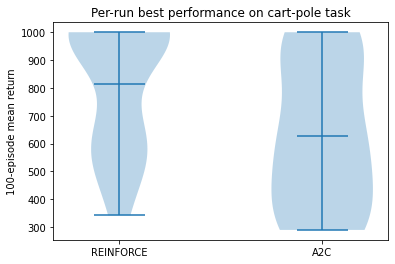

In [18]:
plot_performance(load_records("REINFORCE-cartpole", range(20)), load_records("A2C-cartpole", range(20)), 'cart-pole')

### 3.1.1 REINFORCE results on the cart-pole task {-}

#### 3.1.1.1 Training REINFORCE on the cart-pole task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, the value loss (root mean squared error), and the mean policy objective over 20 runs of 4000 training episodes applying REINFORCE to the cart-pole task.

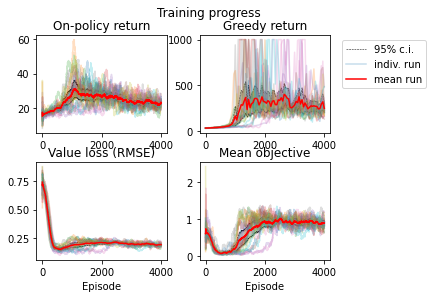

In [17]:
plot_training_curves(load_records("REINFORCE-cartpole", range(20)))

Training on the cart-pole task suffers from instability but is generally able to discover good solutions. Mean performance peaks around episode 500; at this point the runs have a mean on-policy return around 30 (above the chance performance of ~20 to 95% confidence) and a mean greedy return above 400. Most runs discover the optimal policy with a return of 1000 but do not maintain this performance over time. Value loss begins to increase at the same time that a good policy is discovered, likely reflecting the decreased probability of the pole falling over. Given my small network size, it is quite possible that unexplored states' values are being increased alongside the explored states whose values should have been increased, leading to an incorrect baseline estimation. Evidence for this includes that the mean value of the objective function (advantage times log-probability of action) increases from 0 to 1 at this time even as the true quality of the policy decreases on average. However, some perfect policies are discovered even during the objective = 1 phase.

#### 3.1.1.2 Evaluating REINFORCE on the cart-pole task {-}

As seen in the figure at the heading of Section 3.1, the mode run of REINFORCE on the cart-pole task discovers a perfect policy (one that balances the pole for all 1000 timesteps in every episode of a 100-episode evaluation period). The mean run's best policy has a 100-episode mean return of 814.14 and the standard deviation over runs is 226.46. The minimum run's best policy has a 100-episode mean return below 400, meaning that this run did not solve the task as per Sutton and Barto's definition.

### 3.1.2 A2C results on the cart-pole task {-}

#### 3.1.2.1 Training A2C on the cart-pole task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, the value loss (root mean squared error), and the mean policy objective over 20 runs of 4000 training episodes applying A2C to the cart-pole task.

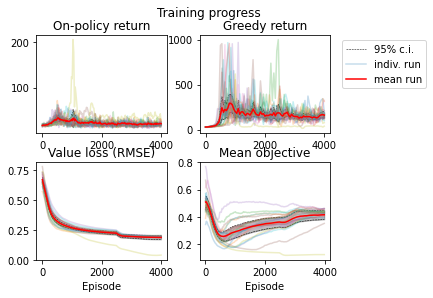

In [22]:
plot_training_curves(load_records("A2C-cartpole", range(20)))

While training A2C on the cart-pole task discovers solutions that certainly perform above chance level, the algorithm's underperformance relative to REINFORCE is clear even from the training plot. Again, mean performance peaks around episode 500 when a good policy is initially discovered; at this point, again, the runs have a mean on-policy return around 30 (not significantly above the chance performance of ~20 because of inter-run variability) and a mean greedy return around 250. A number of runs discover the optimal policy with a mean return of 1000, but this is far less common and less frequent than in REINFORCE's training. Value loss continually decreases, without the period of increase observed in REINFORCE, but the mean objective doe begin to increase around the same time as good policies are discovered.

#### 3.1.2.2 Evaluating A2C on the cart-pole task {-}

As seen in the figure at the heading of Section 3.1, the performance of the best policies discovered by A2C vary almost uniformly between a non-solution performance of 300 and the optimal performance of 1000. The mean run's best policy has a 100-episode mean return of 627.33 and the standard deviation over runs is 258.67.

## 3.2 Results on the half-cheetah task {-}

As seen in the below figure, REINFORCE significantly outperformed A2C on this task. I will further discuss the training curves and the quality of the discovered policies in the following subsections.

REINFORCE on half-cheetah: 40.71285897750116 +/- 43.26014669255462
A2C on half-cheetah: 19.78134669789351 +/- 2.4518493178173606


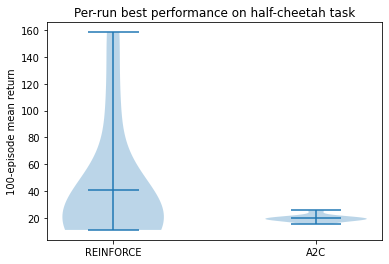

In [28]:
plot_performance(load_records("REINFORCE-cheetah", range(12)), load_records("A2C-cheetah", range(10)), 'half-cheetah')

### 3.2.1 REINFORCE results on the half-cheetah task {-}

#### 3.2.1.1 Training REINFORCE on the half-cheetah task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, the value loss (root mean squared error), and the mean policy objective over 12 runs of 2500 training episodes applying REINFORCE to the half-cheetah task.

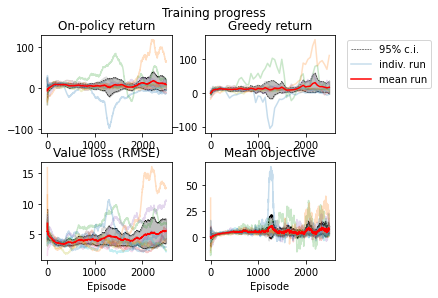

In [27]:
plot_training_curves(load_records("REINFORCE-cheetah", range(12)))

There are three outliers that make it difficult to tell a unified story about REINFORCE's training on the half-cheetah task. I will show the rest of the population here and you may see the training plots for the three outliers in the supplementary materials (Section 6.1).

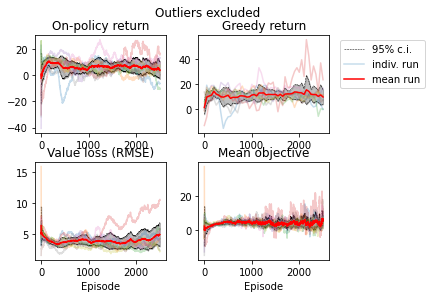

In [43]:
plot_training_curves(load_records("REINFORCE-cheetah", set(range(12)) - {2, 10, 11}), "Outliers excluded")

Excluding the outliers reveals a pattern in which both training and evaluation performance are continuously above zero but also generally short of 30 (the minimum distance at which the cheetah must do more than simply stretch forwards). This strategy of simply stretching forwards is discovered very quickly (generally by the second evaluation phase after 50 training episodes). While a number of runs perform additional exploration (resulting in negative training returns) this exploration is almost never sufficient to break out of the locally optimal "stretch" behavior. Two of the outlier runs clearly surpass this behavior, as do (to a lesser extent) two of the non-outlier runs.

Most runs' value loss hover around 5, but two of the runs see their value loss break out of this pattern. The pink run's loss transiently increases to around 8 during its discovery of a better policy around training episode 1000. The red run's loss makes a sustained increase towards 10 beginning with its initial discovery of a marginally better policy around episode 1200 and continuing through its exploration of worse policies and finally its discovery of a much better policy around episode 2000. Even more interesting patterns can be found in the outliers' value loss (Section 6.1).

Most runs have a positive objective score around 5, but this value exhibits variability during periods of exploration and particularly during periods at which a better policy has been discovered. The red run's objective score occasionally increases to 20, for example. Again, the outliers' objective scores are particularly interesting (Section 6.1).

#### 3.2.1.2 Evaluating REINFORCE on the half-cheetah task {-}

As seen in the figure at the heading of Section 3.2, the mode run of REINFORCE on the half-cheetah task discovers a policy with 100-episode mean return of 25, which represents a fine-tuned stretching behavior and not genuine walking. However, four runs (including two of the outliers) significantly exceed this baseline, with the best discovered policy yielding a 100-episode mean return of 160 over 500 timesteps. The policy's preferred stance is snake-like (as results from the standard stretch policy) and its gait is shuffling, relying primarily on the hind leg for propulsion. When this particular policy was re-evaluated over 1000 timesteps, as in the standard half-cheetah task, it receive a 100-episode mean return of 286.80. This is not quite double the 500-timestep value because the policy does get "stuck" in some episodes, with the agent's body fully collapsing and movement ceasing.

### 3.2.2 A2C results on the half-cheetah task {-}

#### 3.2.2.1 Training A2C on the half-cheetah task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, the value loss (root mean squared error), and the mean policy objective over 10 runs of 2500 training episodes applying A2C to the half-cheetah task.

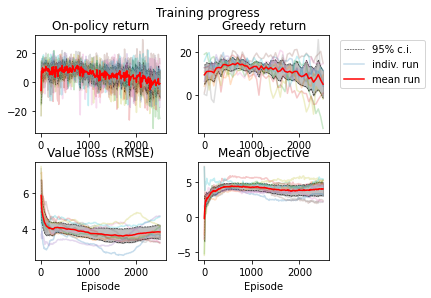

In [25]:
plot_training_curves(load_records("A2C-cheetah", range(10)))

Again, A2C discovers solutions that certainly perform above chance level on the half-cheetah task. However, the algorithm underperforms relative to REINFORCE and it is not clear whether it gains anything from additional run-time beyond 1000 training episodes. Mean performance peaks around episode 500 when all runs have a greedy policy with a mean 100-episode return above 10. Value loss decreases to a mean slightly below 4 halfway through training, at which point the mean loss begins to increase again. At the same time, the mean objective score decreases very slightly from its peak just below 5 before leveling off around episode 2000.

#### 3.2.2.2 Evaluating A2C on the half-cheetah task {-}

As seen in the figure at the heading of Section 3.2, the performance of the best policies discovered by A2C is much less varied than that of those discovered by REINFORCE. The mean and mode run's best policy has a 100-episode mean return of 19.78 and the standard deviation over runs is 2.45.

# 4 Discussion {-}

## 4.1 Comparison between algorithms {-}

In general, A2C underperformed REINFORCE. This is likely due to the training schedule I applied in which REINFORCE would update its baseline and policy using a single episode's data following every episode, and A2C would update its baseline and policy using many episodes' data (representing the many actors) following all of these episodes. This meant that A2C's policy had fewer, larger updates and could more easily draw improper generalizations and skip over regions of high reward in policy space without discovering them. (To test whether this was the issue, it would be interesting to apply a framework such as TRPO or PPO with precisely the same training schedule and observe the results.)

### 4.1.1 REINFORCE vs A2C on the cart-pole task {-}

As seen in the training plots (Sections 3.1.1.1 and 3.1.2.1), A2C's evaluation performance peaks lower and earlier than REINFORCE. This is consistent with an overfitting hypothesis similar to the one I proposed above. One way to evaluate this on this task would be to significantly reduce the A2C training rate for the task, perhaps by a factor of 10, and observe any differences in its performance. Both A2C and REINFORCE are capable of discovering perfect solutions to this problem, and A2C solves the task (achieving a mean 100-episode return of 400) at only a marginally lower rate than REINFORCE.

### 4.1.2 REINFORCE vs A2C on the half-cheetah task {-}

The difference between REINFORCE and A2C is more pronounced on this subtler and more challenging problem. As seen in the training plots (Sections 3.2.1.1 and 3.2.2.1), even when excluding the outliers, REINFORCE's mean training and evaluation loss are consistently above those of A2C, and REINFORCE lacks the downwards trend in performance that A2C exhibits at the end of the training period. In order to increase A2C's performance in this case, it might be valuable to allow more frequent policy updates, including ones that interrupt episodes, even though this would necessitate switching from Monte-Carlo value estimation to estimation using n-step TD bootstrapping. To preserve the scientific nature of the comparison, I could introduce a third treatment that uses n-step bootstrapping but has the training schedule of REINFORCE.

## 4.2 Comparison between tasks {-}

In general, the cart-pole task was much easier than the half-cheetah task. This is predictable from the higher state dimensionality and particularly the higher action dimensionality of the half-cheetah task. All else equal, and assuming a precision of one bit for action (yielding four action bins per dimension) the six-dimensional half-cheetah task is `4**5 = 1024` times harder than the one-dimensional cart-pole problem. I will now discuss the particular results under each algorithm.

### 4.2.1 REINFORCE on the cart-pole task vs the half-cheetah task {-}

As seen in the training plots (Sections 3.1.1.1 and 3.2.1.1), REINFORCE discovers an optimal policy for the cart-pole problem within 2000 training episodes on average. Keep in mind that these training episodes are often extremely short. On the other hand, it only breaks free of the local optimum of stretching forwards four times on the half-cheetah task, and none of these breakthroughs occur before 1000 500-timestep training episodes have elapsed. That said, the half-cheetah value loss and objective function curves exhibit somewhat similar upward trends over time to those displayed early on in the cart-pole training, suggesting that perhaps a far longer training period might help REINFORCE discover better solutions for the half-cheetah problem.

### 4.2.2 A2C on the cart-pole task vs the half-cheetah task {-}

Given all of the theory described so far (A2C has less effective exploration from its sparse policy updates, and the half-cheetah task requires far more exploration than the cart-pole task), it is unsurprising that A2C on the half-cheetah task exhibits the most dismal performance out of all four treatments. Not only does it fail to find successful solutions, it actually exhibits a downwards trend in performance over time. This indicates something deeply imbalanced in its application to the problem.

Interestingly, A2C's value loss curve looks qualitatively quite different on the half-cheetah task (Section 3.2.2.1) compared with the cart-pole task (Section 3.1.2.1). On the cart-pole task, the value loss continually decreases, indicating that the agent is learning the values of states effectively from very early on in training, and that its training policy does not exhibit sudden breakthroughs or failures that might radically change the value function. On the half-cheetah task, on the other hand, the value loss increases midway through training as the training policy's performance actually decreases. This qualitative difference reinforces my impression that the application of A2C to the half-cheetah task needs significant work.

# 5 Learning the half-cheetah from images

## 5.1 Network design

Based on my experience with the Pong assignment, I knew that I would not be able to train my full network end-to-end on this problem in a reasonable amount of time. Instead, I turned to a modular approach using a variational autoencoder as a vision module. For this bonus, I used my preferred variational autoencoder implementation, which I wrote two years ago and adapted for this task. This implementation is based on the VAE used in Schmidhuber and Ha's World Models paper. I use the latent representation of the visual stimuli from the half-cheetah task as the input to my agent.

The main code for my variational autoencoder is included below.

In [46]:
# closely based on my preferred VAE implementation for my own research, which is in turn
# loosely based on https://www.tensorflow.org/tutorials/generative/cvae

# loss functions and encoder/decoder architecture borrowed from Ha's repository at
# https://github.com/hardmaru/WorldModelsExperiments/blob/master/carracing/vae/vae.py
# in order to reproduce the Schmidhuber and Ha results.

def log_normal_pdf(x, mean, std_dev):
    var = std_dev*std_dev
    return -.5 * ((x - mean) ** 2. / var + tf.math.log(var*2*np.pi))

class VAE:
    def __init__(self, inference_conv_layers, generator_deconv_layers, image_shape, latent_dim):
        self.image_shape = image_shape
        self.latent_dim = latent_dim

        self.inference_layers = [tf.keras.layers.InputLayer(input_shape=image_shape)] + \
            inference_conv_layers + [tf.keras.layers.Flatten(), tf.keras.layers.Dense(2*latent_dim)]
        self.inference_net = tf.keras.Sequential(self.inference_layers)
        self.generator_layers = [tf.keras.layers.InputLayer(input_shape=(latent_dim,))] + generator_deconv_layers
        self.generator_net = tf.keras.Sequential(self.generator_layers)

        self.optimizer = tf.keras.optimizers.Adam(0.0005)
    
    ...

    @tf.function
    def sample_latent(self, sample):
        if sample.dtype == tf.uint8:
            sample = tf.cast(sample, 'float32')/255
        if len(sample.shape) == 3:
            unbatched = True
            sample = tf.expand_dims(sample, axis=0)
        else:
            unbatched = False

        latent_info = self.inference_net(sample)
        mean, log_var = tf.split(latent_info, [self.latent_dim, self.latent_dim], -1)

        std_dev = tf.exp(log_var / 2.0)

        sampled_t = tf.random.normal(shape=std_dev.shape)
        sampled_z = mean + std_dev*sampled_t

        if unbatched:
            return sampled_z[0]
        else:
            return sampled_z

    @tf.function
    def train_vae(self, sample):
        ''' Sampling-based approach that gets means and standard deviations
            from inference(sample), then per batch item uses a single std normal
            sample to pick a vector for the generator to use.
            (With small batches and no momentum, this can result in unexpected
            gradients for the std deviation term. Fortunately, we are using Adam here.) '''
        if sample.dtype == tf.uint8:
            sample = tf.cast(sample, 'float32')/255
        latent_info = self.inference_net(sample)
        mean, log_var = tf.split(latent_info, [self.latent_dim, self.latent_dim], -1)

        std_dev = tf.exp(log_var / 2.0)

        sampled_t = tf.random.normal(shape=std_dev.shape)
        sampled_z = mean + std_dev*sampled_t

        new = self.generator_net(sampled_z)

        # lifted from David Ha's github
        # Ha replaces the traditional probability-distribution loss with two things:
        # the error in reconstructing the sample
        reconstruction_loss = tf.reduce_sum((sample-new)**2) / sample.shape[0]
        # and the KL-divergence of the z-distribution from the standard normal distribution
        kl_loss = - 0.5 * tf.reduce_sum(1 + log_var - mean**2 - tf.exp(log_var)) / sample.shape[0]

        loss = reconstruction_loss + kl_loss

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=new, labels=sample) # is this what we want?
        logpsample_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        # the unconditioned latent distribution is assumed to be standard normal:
        logpz = tf.reduce_sum(log_normal_pdf(sampled_z, 0., 1.), axis=[1])
        logqz_sample = tf.reduce_sum(log_normal_pdf(sampled_z, mean, std_dev), axis=[1])
        loss = -tf.reduce_mean(logpsample_z + logpz - logqz_sample)

        vars = self.inference_net.trainable_variables + self.generator_net.trainable_variables
        grads = tf.gradients(loss, vars)
        self.optimizer.apply_gradients(zip(grads, vars))

        return loss

The VAE includes an encoder network and a decoder network. The encoder network consists of four convolution layers, each of which applies 2x2 filters with a stride of 2x2 followed by a ReLU nonlinearity. There are no pooling layers. The convolution layers have 32, 64, 128, and 256 filters, respectively. Following the convolution layers, the feature maps are flattened and fed through a fully-connected layer with a 16-unit linear output that parameterizes the normal distribution of latent-space embeddings of the image. (The first 8 units are the means and the second 8 are the log-variances for the distribution.) Keep in mind that, since a VAE is a probabilistic model for what sort of latent-space representation *might* have yielded the observed surface sample, there is randomness involved in the `sample_latent` method.

The decoder network consists of a single fully-connected ReLU layer that maps the 8-unit latent representation onto a 1x1x1024 representation, followed by four convolution transpose layers, which consist of 128 5x5 filters applied with a stride of 2, 64 5x5 filters applied with a stride of 2, 32 7x7 filters applied with a stride of 2, and 3 6x6 filters applied with a stride of 3x3. This full architecture is identical to the one used in Schmidhuber and Ha's "World Models" paper from a few years ago, except that I use a much smaller 8-unit latent representation instead of their 32-unit representation.

The code to generate a VAE with this specification follows.

In [47]:
# pulled from Schmidhuber & Ha "World Models"
def make_default_vae(image_shape=(96, 96, 3), latent_dim=8):
    sample_inference_conv_layers = [
        tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2), activation='relu')]

    sample_generator_deconv_layers = [tf.keras.layers.Dense(units=1*1*1024, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(1, 1, 1024)),
        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding="VALID", activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=(2, 2), padding="VALID", activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=7, strides=(2, 2), padding="VALID", activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=6, strides=(3, 3), padding="VALID")]

    return VAE(sample_inference_conv_layers, sample_generator_deconv_layers, image_shape, latent_dim)

## 5.2 Training

### 5.2.1 VAE training regime

The goal here is to use random rollouts to obtain a wide variety of images for the half-cheetah task, which should ideally represent a good portion of the distribution that will be encountered during reinforcement learning training. For a previous course project, I studied a possible approach to iteratively train a VAE and the RL agent it acts as a vision module for, but I do not employ that here.

Code to gather and save these images follows. Note that the resulting dataset is 8 GB in size.

In [48]:
class HalfCheetahVAETask:
    def __init__(self, rng, gen_images=False):
        self.vae = make_default_vae(latent_dim=8)

        self.rng = rng

        self.env = gym.make("HalfCheetahMuJoCoEnv-v0")
        self.env.seed(int(rng.integers(2**63-1)))
        self.env.env._render_width = 96
        self.env.env._render_height = 96

        self.obs_shape = (self.vae.latent_dim,)
        self.action_shape = (6,)
        self.cumulative_r = 0

        self.gen_images = gen_images

        if self.gen_images:
            self.im_buffer = np.zeros((1024, 96, 96, 3))
            self.im_buffer_i = 0
        else:
            self.vae.inference_net.load_weights('out/cheetah_inf.tfdat')
            self.vae.generator_net.load_weights('out/cheetah_gen.tfdat')
    
    ...

    def step(self, action):
        _, r, t, _ = self.env.step(action)

        if (not self.gen_images) or self.rng.random() < 0.1:
            vis_obs = self.env.render('rgb_array')

            if self.gen_images:
                self.im_buffer[self.im_buffer_i] = vis_obs
                self.im_buffer_i += 1
                if self.im_buffer_i == self.im_buffer.shape[0]:
                    self.im_buffer = np.concatenate([self.im_buffer, np.zeros((1024, 96, 96, 3))], axis=0)

        if self.gen_images:
            obs = np.zeros(self.obs_shape)
        else:
            obs = self.vae.sample_latent(vis_obs)

        self.cumulative_r += r
        return obs, r, t, _

    def get_samples(self):
        return self.im_buffer[:self.im_buffer_i]

def gen_random_cheetah_rollouts(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.HalfCheetahVAETask(task_rng, no_state=True)

    # expected time to switch action distribution is 10 timesteps
    ag = agent.RandomAgent(agent_rng, 1, task.action_shape, 0.931)

    sim = simulation.Simulation(ag, task, 100)
    sim.run(True)

    np.save('out/half_cheetah_images.npy', task.get_samples())

Following this, we will train the VAE on this dataset for 8 epochs, When training and especially when fine-tuning VAEs, I like to understand how representations are changing over time. Thus, my training code keeps track of and plots the cosine similarity of a sample from the training set as well as the overall loss terms.

In [49]:
def train_vae(vae, training_dataset, distance_sampler):
    losses = []
    distances = []
    first_mean = vae.get_mean(distance_sampler)
    for epoch in range(8):
        total = 0
        count = 0
        for sample in training_dataset:
            loss = vae.train_vae(sample)
            losses.append(loss.numpy())
            current_mean = vae.get_mean(distance_sampler)
            cos = -tf.reduce_mean(tf.keras.losses.cosine_similarity(first_mean, current_mean))
            distances.append(cos.numpy())
            total += loss
            count += 1
            if count % 50 == 0:
                print(count, loss)
        print('Epoch', epoch, total/count)
    ...

def train_cheetah_VAE():
    states = np.load('out/half_cheetah_images.npy')
    np.random.seed(15)
    np.random.shuffle(states)
    states = np.uint8(states)

    minibatch = 256

    training_dataset = tf.data.Dataset.from_tensor_slices(states).batch(minibatch)

    vae = make_default_vae(latent_dim=8)
    train_vae(vae, training_dataset, states[:10])

    vae.inference_net.save_weights('out/cheetah_inf.tfdat')
    vae.generator_net.save_weights('out/cheetah_gen.tfdat')

### 5.2.2 RL training regimes

In both cases, I use the VAE as a vision module and treat it effectively as a preprocessor, expecting the RL algorithms to operate exactly they as they did with the half-cheetah's proprioceptive inputs, except for the fact that the VAE's latent space has 8 dimensions and the original observation space has 17. The code to perform this is included above in the defintion of `HalfCheetahVAETask`.

#### 5.2.2.1 Training a policy for the half-cheetah VAE task using REINFORCE

My regime almost precisely follows the one described in section 2.2.2. In order to train my half-cheetah policy using REINFORCE with a VAE input, I used a temporal discount factor of 0.99 (reward half-life: 62.5 timesteps, constant reward scaling factor: 100) and an action persistence of 0.931 (expected switch time: 10 timesteps). I trained for 2500 episodes (capped at 500 timesteps each) and (as mentioned before) the network architectures were [8, 160, 80, 1] (value) and [8, 160, 180, 18] (policy) with a training rate of 0.00001. The full specification for the REINFORCE half-cheetah VAE simulation is included below.

In [50]:
def test_REINFORCE_cheetah_VAE(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.HalfCheetahVAETask(task_rng)

    path = f'out/REINFORCE-cheetahVAE-{seed}.pickle'

    # expected time to switch action distribution is 10 timesteps
    policy_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, True, task.action_shape, 3)
    value_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, False, task.action_shape, 3)
    ag = agent.AdvantageAgent(agent_rng, 1, policy_network, value_network, 0, 0.99, 0.931, 0)

    sim = simulation.Simulation(ag, task, 2500, path)
    sim.run(False)

#### 5.2.2.2 Training a policy for the half-cheetah VAE task using A2C

My regime almost precisely follows the one described in section 2.3.2. In order to train my half-cheetah policy using A2C with a VAE input, I used a temporal discount factor of 0.99 (reward half-life: 62.5 timesteps, constant reward scaling factor: 100) and an action persistence of 0.931 (expected switch time: 10 timesteps). I included an entropy term weighted by 0.05 in my objective function. I used 10 actors and trained for 250 episode cycles (2500 episodes total). As mentioned before, the network architectures were \[8, 160, 80, 1\] (value) and \[8, 160, 180, 18\] (policy) with a training rate of 0.00001. The full specification for the A2C half-cheetah VAE simulation is included below.

In [51]:
def test_A2C_cheetah_VAE(seed):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task = tasks.HalfCheetahVAETask(task_rng)

    path = f'out/A2C-cheetahVAE-{seed}.pickle'

    # expected time to switch action distribution is 20 timesteps
    policy_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, True, task.action_shape, 3)
    value_network = network.Network(task.obs_shape, network.FFANN_factory([160, 80]), 0.00001, False, task.action_shape, 3)
    ag = agent.AdvantageAgent(agent_rng, 10, policy_network, value_network, 0, 0.99, 0.931, 0.05)

    sim = simulation.Simulation(ag, task, 250, path)
    sim.run(False)

### 5.2.3 Main VAE simulations

Enable the following cell to generate new random rollouts for the half-cheetah task and train the VAE. Again, this will consume 8 GB of disk space.

In [52]:
enable_vae_training = False

# enable_vae_training = True

if enable_vae_training:
    gen_random_cheetah_rollouts(0)
    
    train_cheetah_VAE()

Enable and execute the following cell to repeat the experiments applying the two RL algorithms using a VAE to the task.

In [53]:
enable_simulations_vae = False

# enable_simulations_vae = True

if enable_simulations_vae:
    for i in range(2):
        test_REINFORCE_cheetah_VAE(i)
        test_A2C_cheetah_VAE(i)

## 5.3 Evaluation

See the best-in-run performance of REINFORCE and A2C when trained on the half-cheetah task using image inputs. Each population plot consists of two runs which are naturally at the minimum and maximum of the population.

REINFORCE on half-cheetah (VAE): 12.26773384708994 +/- 3.2090416874199335
A2C on half-cheetah (VAE): 29.98162204541603 +/- 17.119321286552527


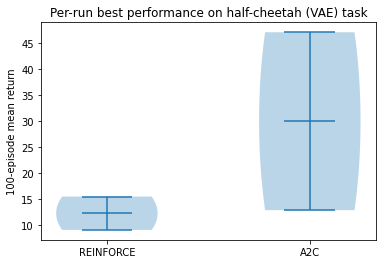

In [55]:
plot_performance(load_records("REINFORCE-cheetahVAE", range(2)), load_records("A2C-cheetahVAE", range(2)), 'half-cheetah (VAE)')

### 5.3.1 REINFORCE on the half-cheetah with image inputs {-}

#### 5.3.1.1 REINFORCE training results {-}

While they were not identical, the two runs included similar trends. Nevertheless, I plot them separately here for clarity.

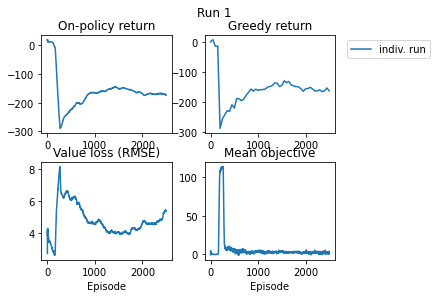

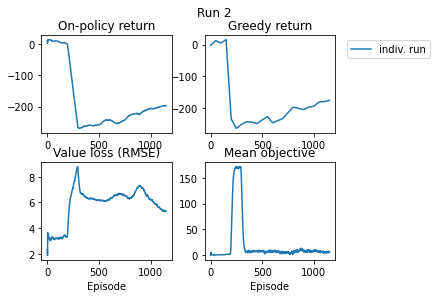

In [66]:
plot_training_curves(load_records("REINFORCE-cheetahVAE", [0]), "Run 1")
plot_training_curves(load_records("REINFORCE-cheetahVAE", [1]), "Run 2")

As seen above, performance is near chance for the first 250 episodes before suddenly dropping and becoming very negative. There is a roughly 100-episode gap between the time this takes place for the two runs. This very negative reward is maintained for the remainder of training but there is an upwards trend towards the 1000-episode mark. Nevertheless, performance is not impressive to say the least.

#### 5.3.1.2 REINFORCE evaluation results {-}

The run-best performance (mean over 2 runs) for REINFORCE with VAE inputs is 12.3 with a standard deviation of 3.2. This is chance performance.

### 5.3.2 A2C on the half-cheetah with image inputs {-}

#### 5.3.2.1 A2C training results {-}

Performance was so different for the two runs that I opted to show them separately.

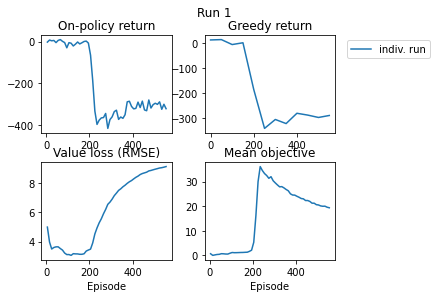

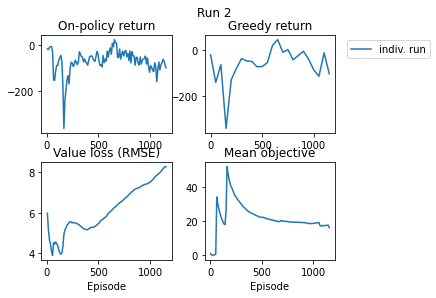

In [67]:
plot_training_curves(load_records("A2C-cheetahVAE", [0]), "Run 1")
plot_training_curves(load_records("A2C-cheetahVAE", [1]), "Run 2")

The two A2C runs exhibit very different performance over training from REINFORCE and from each other. The first run performs around chance for 200 episodes before falling off a performance cliff, likely as a result of some artifact or degeneracy in its value function. It is an important feature of training from VAE representations that two distinct states might have the same representation in the VAE, and this is likely what caused the issue with the value function here.

The second run performs worse than chance for most of its 1000-episode duration, but very briefly spikes at around 600-episodes to a behavior well above chance performance, with a mean return of 46 over 100 episodes. After this point, the value loss continues to rise over time, but it is difficult to interpret what this continual increase might mean as opposed to the brief spike one would expect from such a breakthrough.

#### 5.3.2.2 A2C evaluation results {-}

The run-best performance (mean over 2 runs) for A2C with VAE inputs is 29.98 with a standard deviation of 17.11. This is above chance performance.

## 5.4 Discussion {-}

In general, performance was worse on the half-cheetah task using image inputs than using state vectors. A major cause of this was that I provided the agent with only the most recent image's latent representations rather than two images' latent representations. Thus, the agent had no access to velocity data, which was a major component of the state vector that it received in the standard half-cheetah task. Additionally, it may be possible that the 8-dimensional latent space used was too small to encode all relevant information.

### 5.4.1 Comparing REINFORCE with state vectors vs with images {-}

REINFORCE performs much worse with image representations than it does with state vectors. There are a number of possible causes for this which I discussed above but one particular to REINFORCE is that, given the low-dimensional latent representations used, two states will frequently have the same latent representation. Because REINFORCE is trained on one rollout at a time, it will directly learn from these representations with only Adam's momentum and limited learning rate preventing it from fully discounting its previous value data.

### 5.4.2 Comparing A2C with state vectors vs with images {-}

Interestingly, the best solution A2C discovered from images was better than the one it discovered from vectors. However, training was even more unstable with very common negative rewards. One possible cause for this good performance is that the VAE's state degeneracy actually provides a sort of exploration to the agent, causing it to act in novel ways that it would not have done had all of the states been represented accurately. If this is the case, then it is not in fact a desirable effect in general.

### 5.4.3 Comparing REINFORCE with A2C on images {-}

While REINFORCE significantly outperformed A2C on state vectors, the opposite holds for image representations. I argue in Section 5.4.1 that this is the case because two states will frequently have the same image representation, and the uncorrelated samples from A2C will better help the agent cope with the gradients resulting from these conflicts.

# 6 Supplementary materials {-}

## 6.1 Outliers when training REINFORCE on the half-cheetah task {-}

These outlier runs reveal a significant amount about the process of training REINFORCE on the half-cheetah task and suggest directions for changing hyperparameters to improve performance. Due to time constraints I do not discuss them in depth here.

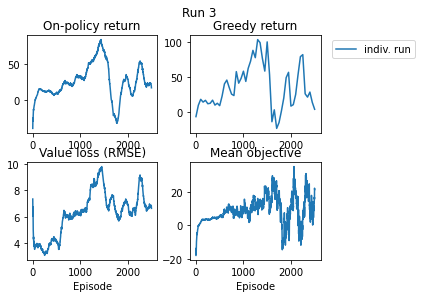

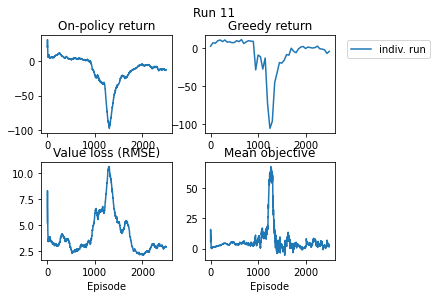

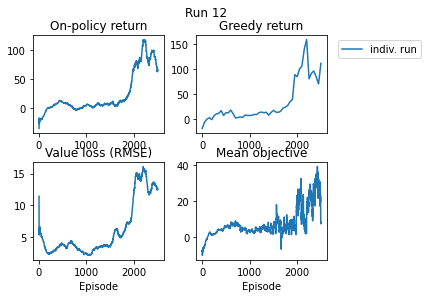

In [44]:
plot_training_curves(load_records("REINFORCE-cheetah", [2]), "Run 3")
plot_training_curves(load_records("REINFORCE-cheetah", [10]), "Run 11")
plot_training_curves(load_records("REINFORCE-cheetah", [11]), "Run 12")

In [ ]:
## 6.2 Code availability

To find a 